# Time Series Analysis of `Apple, Inc.` stock values

Time series analysis refers to the analysis of change in the trend of the data over a period of time. Time series analysis has a variety of applications. One such application is the prediction of the future value of an item based on its past values.  
We will demonstrate time series analysis with the help of an LSTM network. We will be predicting the future stock prices of the Apple Company (AAPL), based on its stock prices of the past 7 years.

For various manipulations we will need Numpy and will plot the results using matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from tensorflow import keras

I am just curious whether my GPU card is still visible, so let me do the following.

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17126832191030174320
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40161050624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12983294677576885957
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


The above will work on Google Colab as well, provided you change the runtime and select GPU.

As a data set we will fetch a long string of stock values for a company at Yahoo Finance. For example https://finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch .
You adjust the start date and the end data of the report and then download the dataset. Fot training data we selected the period between January 4th 2016 to August 31st, 2023. Downloaded data is stored in the file AAPL.csv
To test the predictive power of LSTM, we will use the Apple stock prices from the first day of September till October 20th, 2023. So, in order to evaluate the performance of the algorithm, as the test data, create a separate file with Apple's stock prices between September 1st and October 20th, 2023.  

Downloaded data are loaded in a panda. Besides the date index, downloaded data have 6 features: Open,	High,	Low,	Close,	Adj Close, and	Volume.
    At the moment, we do not care about all of those features. We will look only at the opening price and ignore the others.

In [4]:
import cv2
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
microsoft_training_complete = pd.read_csv(r'/content/gdrive/MyDrive/ColabNotebooks/Stocks/MSFT_trunc.csv')

In [6]:
microsoft_training_complete

,Date,Open,High,Low,Close,Volume
0,2017-01-03,62.790001,62.840000,62.130001,62.580002,20694100
1,2017-01-04,62.480000,62.750000,62.119999,62.299999,21340000
2,2017-01-05,62.189999,62.660000,62.029999,62.299999,24876000
3,2017-01-06,62.299999,63.150002,62.040001,62.840000,19922900
4,2017-01-09,62.759998,63.080002,62.540001,62.639999,20382700
...,...,...,...,...,...,...
1672,2023-08-25,321.470001,325.359985,318.799988,322.980011,21684100
1673,2023-08-28,325.660004,326.149994,321.720001,323.700012,14808500
1674,2023-08-29,321.880005,328.980011,321.880005,328.410004,19284600
1675,2023-08-30,328.670013,329.809998,326.450012,328.790009,15222100


<Axes: xlabel='Date'>

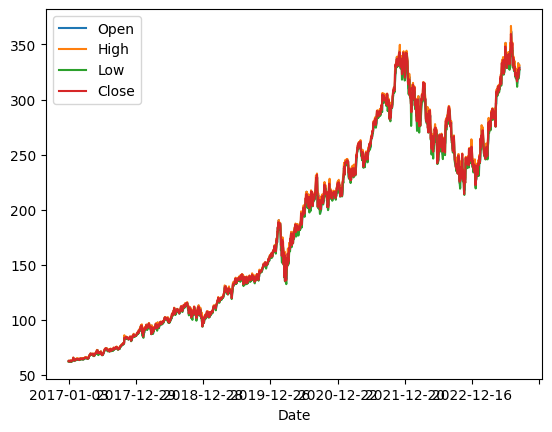

In [7]:
microsoft_training_complete.plot(x='Date',y=['Open','High', 'Low','Close'])

<Axes: xlabel='Date'>

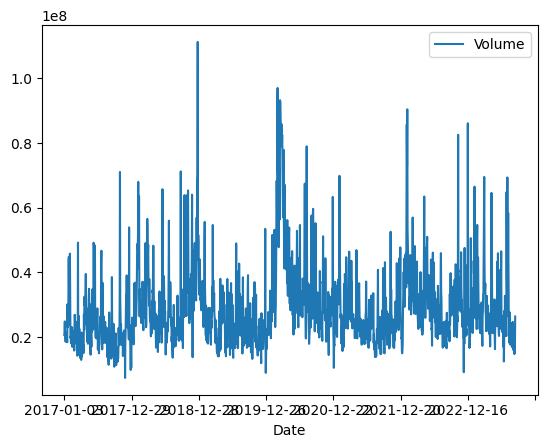

In [8]:
microsoft_training_complete.plot(x='Date',y=['Volume'])

In [9]:
microsoft_training_processed = microsoft_training_complete.iloc[:, 1:6].values

In [10]:
print(microsoft_training_processed)
print("length of the dataset: ", microsoft_training_processed.size)

[[6.27900010e+01 6.28400000e+01 6.21300010e+01 6.25800020e+01
  2.06941000e+07]
 [6.24800000e+01 6.27500000e+01 6.21199990e+01 6.22999990e+01
  2.13400000e+07]
 [6.21899990e+01 6.26600000e+01 6.20299990e+01 6.22999990e+01
  2.48760000e+07]
 ...
 [3.21880005e+02 3.28980011e+02 3.21880005e+02 3.28410004e+02
  1.92846000e+07]
 [3.28670013e+02 3.29809998e+02 3.26450012e+02 3.28790009e+02
  1.52221000e+07]
 [3.29200012e+02 3.30910004e+02 3.26779999e+02 3.27760010e+02
  2.64110000e+07]]
length of the dataset:  8385


We want to normilize our data and will use SciKitLearn `MinMaxScaler` from sklearn.preprocessing libary. All values of `Open`(ing) price will be scaled to the interval between 0 and 1.

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

microsoft_training_scaled = scaler.fit_transform(microsoft_training_processed)


In [12]:
print(type(microsoft_training_scaled))
microsoft_training_scaled

<class 'numpy.ndarray'>


array([[2.00294431e-03, 5.91871632e-04, 6.19642671e-04, 9.42168338e-04,
        1.27807237e-01],
       [9.68089862e-04, 2.95935816e-04, 5.85211193e-04, 0.00000000e+00,
        1.34028791e-01],
       [0.00000000e+00, 0.00000000e+00, 2.75389858e-04, 0.00000000e+00,
        1.68088888e-01],
       ...,
       [8.66904811e-01, 8.75706997e-01, 8.94798455e-01, 8.95420482e-01,
        1.14230397e-01],
       [8.89571415e-01, 8.78436140e-01, 9.10530518e-01, 8.96699142e-01,
        7.50988523e-02],
       [8.91340673e-01, 8.82053153e-01, 9.11666485e-01, 8.93233349e-01,
        1.82874591e-01]])

In a time series problem, we usually predict a value at time T, based on the data from the previous N time steps. In our case, we will predict `Open` price on day T, based on `Open` prices on days T-1,T-2,..., T-N. The number of steps (days), N, could be arbitray. Concretely, we will predict the opening stock price of the data based on the opening stock prices for the past 30 days. One presumes that larger N will give higher prediction. However, larger N will most probably result in longer training and possibly some loss of numerical precision.

In [13]:
print(microsoft_training_scaled.shape)
print(microsoft_training_scaled)

(1677, 5)
[[2.00294431e-03 5.91871632e-04 6.19642671e-04 9.42168338e-04
  1.27807237e-01]
 [9.68089862e-04 2.95935816e-04 5.85211193e-04 0.00000000e+00
  1.34028791e-01]
 [0.00000000e+00 0.00000000e+00 2.75389858e-04 0.00000000e+00
  1.68088888e-01]
 ...
 [8.66904811e-01 8.75706997e-01 8.94798455e-01 8.95420482e-01
  1.14230397e-01]
 [8.89571415e-01 8.78436140e-01 9.10530518e-01 8.96699142e-01
  7.50988523e-02]
 [8.91340673e-01 8.82053153e-01 9.11666485e-01 8.93233349e-01
  1.82874591e-01]]


In the script below we create two lists: feature_set and labels. There are 1928 records in the training data. We execute a loop that starts from 61st record and stores 60 records at the beginning to the feature_set list. The 61st record is stored in the labels list. Then we move the cursor by one point and repeate the mapping.

In [14]:
microsoft_training_scaled1 = microsoft_training_scaled[0:65]

In [31]:
print(microsoft_training_scaled.shape)
print(microsoft_training_scaled.ravel().shape)
print(type(microsoft_training_scaled.ravel()))
#microsoft_training_scaled.flatten
#print(type(microsoft_training_scaled.flatten))
microsoft_training_scaled_ravel = microsoft_training_scaled.ravel()

(1677, 5)
(8385,)
<class 'numpy.ndarray'>


In [21]:
microsoft_training_scaled_ravel

array([2.00294431e-03, 5.91871632e-04, 6.19642671e-04, ...,
       9.11666485e-01, 8.93233349e-01, 1.82874591e-01])

In [15]:
dataset = keras.utils.timeseries_dataset_from_array(
 data= microsoft_training_scaled[:],
 targets=microsoft_training_scaled[60:],
 sequence_length=60,
 batch_size=1,
 #start_index=2
)

In [16]:
print(microsoft_training_scaled1[60:65])


[[0.01078248 0.01091675 0.01173879 0.01147414 0.07414236]
 [0.01155028 0.01160727 0.01204859 0.01197888 0.13114197]
 [0.01208439 0.01078522 0.01115357 0.01093578 0.12498302]
 [0.01068233 0.01035775 0.01146338 0.01154145 0.0536697 ]
 [0.01372014 0.01213336 0.01201419 0.01096941 0.13507487]]


In [17]:
features_set = []
labels = []
for inputs, targets in dataset:
  #print(inputs.shape)
  #print(targets.shape)
  #print(type(inputs))
  #print(type(targets))
  for i in range (inputs.shape[0]):
    #print([int(x) for x in inputs[i]], int(targets[i]))
    #print('inputs',np.array(inputs[i]))
    #print("\n\n")
    #print('targets', np.array(targets[i][0]) )
    #print("\n\n")
    #for x in inputs[i]:
    features_set.append(np.array(inputs[i]))
    labels.append(np.array(targets[i][0]))

In [18]:
print(type(features_set))
print(type(labels))
print(len(features_set))
print(len(labels))
#print(features_set.shape)
#print(labels.shape)
#print(features_set)
#print(labels)

<class 'list'>
<class 'list'>
1617
1617


In [19]:
for x in labels[0:5]:
    print(x)

0.010782477597868628
0.011550283710941772
0.012084387060741109
0.010682334054338577
0.0137201361539587


In [ ]:
'''
for x in features_set:
    print(x)
    #print(type(x.ravel()))
'''

We need to convert both the `feature_set` and the `labels list` to numpy arrays before we could use them for training. Execute the following code:

In [20]:
print(len(features_set))
print(len(labels))
#print(features_set.shape)
#print(labels.shape)
print(len(features_set[0]))

print(labels[0])
print(features_set[0])

1617
1617
60
0.010782477597868628
[[2.00294431e-03 5.91871632e-04 6.19642671e-04 9.42168338e-04
  1.27807237e-01]
 [9.68089862e-04 2.95935816e-04 5.85211193e-04 0.00000000e+00
  1.34028791e-01]
 [0.00000000e+00 0.00000000e+00 2.75389858e-04 0.00000000e+00
  1.68088888e-01]
 [3.67205233e-04 1.61121268e-03 3.09821335e-04 1.81702284e-03
  1.20378745e-01]
 [1.90278742e-03 1.38104038e-03 2.03105098e-03 1.14404930e-03
  1.24807714e-01]
 [1.80264721e-03 1.34815205e-03 1.13600468e-03 1.07675228e-03
  1.07568643e-01]
 [1.40206302e-03 1.87426017e-03 1.65237701e-03 2.99471727e-03
  1.35736612e-01]
 [2.90426625e-03 2.43325662e-03 0.00000000e+00 1.04311050e-03
  1.30447472e-01]
 [1.43543864e-03 6.90513615e-04 1.37697339e-03 1.34594708e-03
  1.15556776e-01]
 [1.63573574e-03 1.31530317e-04 2.75389858e-04 7.73915700e-04
  1.27517302e-01]
 [1.60234677e-03 1.31530317e-04 5.85211193e-04 6.72973539e-04
  1.17943679e-01]
 [1.66921484e-04 1.05221623e-03 8.60614820e-04 0.00000000e+00
  1.06207587e-01]
 [1.60

In [21]:
features_set, labels = np.array(features_set), np.array(labels)

What are the dimensions of the feature set?

In [22]:
print(features_set.shape)
print(features_set.shape[0], features_set.shape[1])

(1617, 60, 5)
1617 60


In [23]:
print(labels.shape)
print(labels)

(1617,)
[0.01078248 0.01155028 0.01208439 ... 0.86690481 0.88957142 0.89134067]


## Convert Training Data to Right Shape
In order to train LSTM, we need to convert our data into the shape accepted by the LSTM.
LSTM expects a three-dimensional format.
The first dimension is the number of records or rows in the dataset which is 1868 in our case.
The second dimension is the number of time steps which is 60.
The last dimension is the number of indicators. Since we are only using one feature, i.e Open, the number of indicators will be 1. Execute the following:

In [24]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 5))

In [25]:
print(features_set.shape)

(1617, 60, 5)


## Traning the LSTM
We will use Keras API.  
The LSTM model we will create is sequential model with multiple layers. We will use four LSTM layers followed by a dense layer that predicts the future stock price.
Let's first import the libraries that we will need in order to create our model:

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

## Building the Model

As a first step, we need to instantiate the Sequential class. This is our model class. We will add LSTM, Dropout and Dense layers to this model. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The second parameter is `return_sequences`, which is set to `True` since we will add more layers to the model. The first parameter to the `input_shape` is the number of time steps while the last parameter is the number of indicators.

`return_sequences`=`True`: `Boolean`. Whether to return the last output in the output sequence, or the full sequence. That return sequences return the hidden state output for each input time step. When stacking LSTM layers you must set `return_sequnce` to `True`
We are leaving
`unroll=False`: `Boolean` (default `False`). If `True`, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 5),unroll=False))

To avoid over-fitting, we will add Dropout layers after every LSTM layer.

In [28]:
model.add(Dropout(0.2))

In [29]:
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))


The number of neurons, units = 50, in every LSTM subcell is somewhat arbitrary. You should play with that parameter and find an optimal value

## Creating a Dense Layer

To make our model more robust, we add a Dense layer at the end of the model. The number of neurons in the Dense layer will be set to 1 since we want to predict a single value in the output.


In [30]:
model.add(Dense(units = 1))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

## Model Compilation
Finally, we need to compile our LSTM model before we can train it on the training data.

In [32]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Model Training
Now is the time to train the model that we defined in the previous few steps. To do so, we call the `fit` method on the model and pass it our training features and labels as shown below:


In [33]:
history = model.fit(features_set, labels, epochs = 100, batch_size = 1)

Epoch 1/100
1617/1617 [==============================] - 28s 11ms/step - loss: 0.0077
Epoch 2/100
1617/1617 [==============================] - 17s 11ms/step - loss: 0.0039
Epoch 3/100
1617/1617 [==============================] - 17s 10ms/step - loss: 0.0036
Epoch 4/100
1617/1617 [==============================] - 17s 10ms/step - loss: 0.0030
Epoch 5/100
1617/1617 [==============================] - 17s 11ms/step - loss: 0.0029
Epoch 6/100
1617/1617 [==============================] - 17s 10ms/step - loss: 0.0025
Epoch 7/100
1617/1617 [==============================] - 17s 10ms/step - loss: 0.0022
Epoch 8/100
1617/1617 [==============================] - 17s 11ms/step - loss: 0.0023
Epoch 9/100
1617/1617 [==============================] - 17s 11ms/step - loss: 0.0020
Epoch 10/100
1617/1617 [==============================] - 17s 11ms/step - loss: 0.0019
Epoch 11/100
1617/1617 [==============================] - 17s 11ms/step - loss: 0.0018
Epoch 12/100
1617/1617 [============================

In [34]:
from tensorflow.keras.models import load_model
model.save('microsoft_Prob3.h5')
#model = load_model('apple.h5')
history_dict = history.history
history_dict.keys()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss'])

From the above, we see that our model history contains information only on the training loss. Had we had validation data passed to the training process we would have had validation loss and perhaps accuracy available as well.

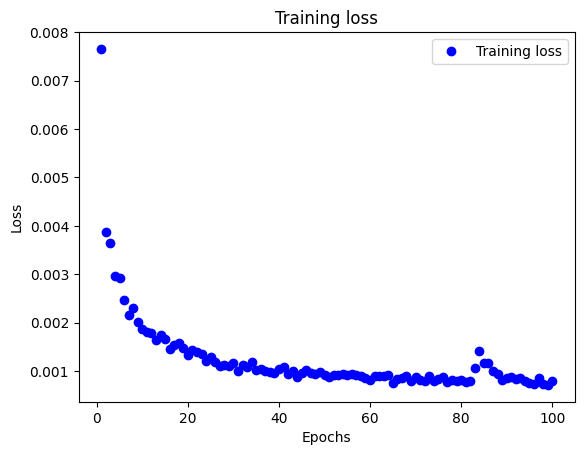

In [35]:
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# **The Loss increases around 80 through 90 epochs**

## Testing our LSTM
We have successfully trained our LSTM, now we will test the performance of our network on the test set containing the opening stock prices for the month of September and a part of October 2023.

As we did with the training data, we need to convert our test data to the right format. We first import our test data. The test data contain only prices for 34 days and has no overlap with the training data.

Execute the following:


In [73]:
microsoft_testing_complete = pd.read_csv(r'/content/gdrive/MyDrive/ColabNotebooks/Stocks/MSFT_test.csv')
microsoft_testing_processed = microsoft_testing_complete.iloc[:, 1:6].values
microsoft_testing_processed
print("Number of data points in test data: ", microsoft_testing_processed.size)

Number of data points in test data:  200


In [74]:
microsoft_testing_processed

array([[3.31309998e+02, 3.31989990e+02, 3.26779999e+02, 3.28660004e+02,
        1.49312000e+07],
       [3.29000000e+02, 3.34850006e+02, 3.28660004e+02, 3.33549988e+02,
        1.85539000e+07],
       [3.33380005e+02, 3.34459991e+02, 3.30179993e+02, 3.32880005e+02,
        1.75358000e+07],
       [3.31290009e+02, 3.33079987e+02, 3.29029999e+02, 3.29910004e+02,
        1.83810000e+07],
       [3.30089996e+02, 3.36160004e+02, 3.29459991e+02, 3.34269989e+02,
        1.95301000e+07],
       [3.37239990e+02, 3.38420013e+02, 3.35429993e+02, 3.37940002e+02,
        1.65833000e+07],
       [3.35820007e+02, 3.36790009e+02, 3.31480011e+02, 3.31769989e+02,
        1.75655000e+07],
       [3.31309998e+02, 3.36850006e+02, 3.31170013e+02, 3.36059998e+02,
        1.65444000e+07],
       [3.39149994e+02, 3.40859985e+02, 3.36570007e+02, 3.38700012e+02,
        2.02670000e+07],
       [3.36920013e+02, 3.37399994e+02, 3.29649994e+02, 3.30220001e+02,
        3.76669000e+07],
       [3.27799988e+02, 3.3039

## Converting Test Data to Right Format

For each day in the test set, we want our feature set to contain the opening stock prices for the previous 60 days, what is almost 3 months. To do so, we need to concatenate our training data and test data before preprocessing. Execute the following:


In [75]:
#microsoft_total = pd.concat((microsoft_training_complete['Open'], microsoft_testing_complete['Open']), axis=0)

In [76]:
microsoft_total = pd.concat((microsoft_training_complete, microsoft_testing_complete), axis=0)

In [77]:
microsoft_total

,Date,Open,High,Low,Close,Volume
0,2017-01-03,62.790001,62.840000,62.130001,62.580002,20694100
1,2017-01-04,62.480000,62.750000,62.119999,62.299999,21340000
2,2017-01-05,62.189999,62.660000,62.029999,62.299999,24876000
3,2017-01-06,62.299999,63.150002,62.040001,62.840000,19922900
4,2017-01-09,62.759998,63.080002,62.540001,62.639999,20382700
...,...,...,...,...,...,...
35,2023-10-23,325.470001,332.730011,324.390015,329.320007,24374700
36,2023-10-24,331.299988,331.839996,327.600006,330.529999,31153600
37,2023-10-25,345.019989,346.200012,337.619995,340.670013,55053800
38,2023-10-26,340.540009,341.630005,326.940002,327.890015,37828500


Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 34 test days and stock prices from the last 60 days from the training set. Execute the following code to fetch those 94 values.

In [78]:
test_inputs = microsoft_total[len(microsoft_total) - len(microsoft_testing_complete) - 60:].values

In [79]:
print(test_inputs.shape)
print(len(test_inputs))
print(test_inputs)

(100, 6)
100
[['2023-06-07' 331.649994 334.48999 322.5 323.380005 40717100]
 ['2023-06-08' 323.940002 326.640015 323.350006 325.26001 23277700]
 ['2023-06-09' 324.98999 329.98999 324.410004 326.790009 22514900]
 ['2023-06-12' 328.579987 332.100006 325.160004 331.850006 24260300]
 ['2023-06-13' 334.470001 336.980011 330.390015 334.290009 22951300]
 ['2023-06-14' 334.339996 339.040009 332.809998 337.339996 26003800]
 ['2023-06-15' 337.480011 349.839996 337.200012 348.100006 38899100]
 ['2023-06-16' 351.320007 351.470001 341.950012 342.329987 46533600]
 ['2023-06-20' 339.309998 342.079987 335.859985 338.049988 26375400]
 ['2023-06-21' 336.369995 337.730011 332.070007 333.559998 25117800]
 ['2023-06-22' 334.119995 340.119995 333.339996 339.709991 23556800]
 ['2023-06-23' 334.359985 337.959991 333.450012 335.019989 23084700]
 ['2023-06-26' 333.720001 336.109985 328.48999 328.600006 21520600]
 ['2023-06-27' 331.859985 336.149994 329.299988 334.570007 24354100]
 ['2023-06-28' 334.660004 337.9

As we did for the training set, we need to scale our test data. We will use already defined `scalar` object. Execute the following:

In [80]:
print(test_inputs.shape)
#test_inputs = test_inputs.reshape(-1,5)
test_inputs1 = test_inputs[:,1:]
print(test_inputs1.shape)
print(test_inputs1)
test_inputs1 = scaler.transform(test_inputs1)
print(test_inputs1)

(100, 6)
(100, 5)
[[331.649994 334.48999 322.5 323.380005 40717100]
 [323.940002 326.640015 323.350006 325.26001 23277700]
 [324.98999 329.98999 324.410004 326.790009 22514900]
 [328.579987 332.100006 325.160004 331.850006 24260300]
 [334.470001 336.980011 330.390015 334.290009 22951300]
 [334.339996 339.040009 332.809998 337.339996 26003800]
 [337.480011 349.839996 337.200012 348.100006 38899100]
 [351.320007 351.470001 341.950012 342.329987 46533600]
 [339.309998 342.079987 335.859985 338.049988 26375400]
 [336.369995 337.730011 332.070007 333.559998 25117800]
 [334.119995 340.119995 333.339996 339.709991 23556800]
 [334.359985 337.959991 333.450012 335.019989 23084700]
 [333.720001 336.109985 328.48999 328.600006 21520600]
 [331.859985 336.149994 329.299988 334.570007 24354100]
 [334.660004 337.980011 333.809998 335.850006 20259500]
 [334.709991 336.109985 332.619995 335.049988 16997000]
 [337.75 342.730011 337.200012 340.540009 26823800]
 [339.190002 340.899994 336.570007 337.98999

We scaled our data, now let's prepare our final test input set that will contain previous 60 stock prices from the training_set. Execute the following:

In [ ]:
'''
print(test_inputs.shape)
test_inputs_ravel=test_inputs.ravel()
print(test_inputs_ravel.shape)
'''

In [ ]:
'''
test_features = []
for i in range(60, 94):
    test_features.append(test_inputs[i-60:i, 0])
'''

In [82]:
dataset = keras.utils.timeseries_dataset_from_array(
 data= test_inputs1[:],
 targets=test_inputs1[60:],
 sequence_length=60,
 batch_size=1,
 #start_index=2
)

In [83]:
test_features = []

for inputs, targets in dataset:
  #print(inputs.shape)
  #print(targets.shape)
  #print(type(inputs))
  #print(type(targets))
  for i in range (inputs.shape[0]):
    #print([int(x) for x in inputs[i]], int(targets[i]))
    #print('inputs',np.array(inputs[i]))
    #print("\n\n")
    #print('targets', np.array(targets) )
    #print("\n\n")
    #for x in inputs[i]:
    test_features.append(np.array(inputs[i]))


In [85]:
print(len(test_features))
#print(features_set.shape)
print(len(test_features[0]))
print(test_features)


40
60
[array([[0.89951928, 0.89382478, 0.89693276, 0.87849529, 0.32067639],
       [0.87378155, 0.86801268, 0.89985887, 0.88482122, 0.15269345],
       [0.87728665, 0.87902799, 0.90350787, 0.88996944, 0.14534587],
       [0.88927089, 0.88596609, 0.90608972, 0.90699558, 0.16215823],
       [0.90893311, 0.9020124 , 0.92409382, 0.91520582, 0.14954945],
       [0.90849912, 0.90878604, 0.93242451, 0.92546857, 0.17895229],
       [0.91898121, 0.94429829, 0.94753695, 0.9616744 , 0.30316472],
       [0.96518229, 0.94965804, 0.96388864, 0.94225915, 0.37670313],
       [0.92509013, 0.91878202, 0.94292397, 0.92785759, 0.18253168],
       [0.91527572, 0.90447853, 0.92987712, 0.91274944, 0.170418  ],
       [0.90776471, 0.91233722, 0.93424901, 0.93344325, 0.15538185],
       [0.90856585, 0.90523475, 0.93462773, 0.9176621 , 0.1508344 ],
       [0.90642943, 0.8991516 , 0.91755306, 0.89605981, 0.1357684 ],
       [0.90022027, 0.89928316, 0.92034144, 0.91614797, 0.16306175],
       [0.90956738, 0.90530

In [86]:
test_features = np.array(test_features)

In [87]:
print(test_features.shape)
print(test_features.shape[0], test_features.shape[1])

(40, 60, 5)
40 60


In [88]:
features_set = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 5))

In [89]:
print(test_features.shape)

(40, 60, 5)


In [ ]:
'''
test_features = []
for i in range(60, 94):
    test_features.append(test_inputs[i-60:i, 0])
'''

Finally, we need to convert our data into the three-dimensional format which can be used as input to the LSTM. Execute the following code

In [ ]:
'''
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
print(test_features.shape)
'''

(34, 60, 1)


## Making Predictions
We preprocessed our test data and now we can use it to make predictions. To do so, we simply need to call the `predict()` method on the model that we trained. Execute the following


In [161]:
predictions = model.predict(test_features)

2/2 [==============================] - 0s 7ms/step


Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we use the `ìnverse_transform` method of the `scaler` object we created during training. This is accomplished with the following:

In [162]:
predictions

array([[0.8614814 ],
       [0.86486506],
       [0.87250614],
       [0.8721655 ],
       [0.86983895],
       [0.8747195 ],
       [0.88415605],
       [0.8770656 ],
       [0.87956303],
       [0.8878013 ],
       [0.87398326],
       [0.86980915],
       [0.86714405],
       [0.8522849 ],
       [0.84690464],
       [0.84083486],
       [0.83495164],
       [0.82233036],
       [0.82100284],
       [0.8186641 ],
       [0.8266214 ],
       [0.8360717 ],
       [0.82284075],
       [0.8311404 ],
       [0.83302414],
       [0.84497046],
       [0.85625106],
       [0.8612881 ],
       [0.8684287 ],
       [0.8701085 ],
       [0.86401206],
       [0.87385607],
       [0.8716243 ],
       [0.8683077 ],
       [0.87545276],
       [0.86499864],
       [0.86418843],
       [0.86954486],
       [0.8887134 ],
       [0.8768233 ]], dtype=float32)

In [163]:
print(type(predictions))

<class 'numpy.ndarray'>


In [169]:
#print(np.zeros(40))
#print(predictions)
pred=np.c_[ predictions, np.zeros(40),np.zeros(40),np.zeros(40),np.zeros(40) ]


print(pred)


[[0.86148143 0.         0.         0.         0.        ]
 [0.86486506 0.         0.         0.         0.        ]
 [0.87250614 0.         0.         0.         0.        ]
 [0.8721655  0.         0.         0.         0.        ]
 [0.86983895 0.         0.         0.         0.        ]
 [0.8747195  0.         0.         0.         0.        ]
 [0.88415605 0.         0.         0.         0.        ]
 [0.8770656  0.         0.         0.         0.        ]
 [0.87956303 0.         0.         0.         0.        ]
 [0.88780129 0.         0.         0.         0.        ]
 [0.87398326 0.         0.         0.         0.        ]
 [0.86980915 0.         0.         0.         0.        ]
 [0.86714405 0.         0.         0.         0.        ]
 [0.85228491 0.         0.         0.         0.        ]
 [0.84690464 0.         0.         0.         0.        ]
 [0.84083486 0.         0.         0.         0.        ]
 [0.83495164 0.         0.         0.         0.        ]
 [0.82233036 0

In [166]:
pred_inv = scaler.inverse_transform(pred)

In [167]:
pred_inv

array([[3.20255376e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.21268979e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.23557940e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.23455897e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.22758957e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.24220973e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.27047786e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.24923771e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.25671902e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.28139754e+02, 6.26600000e+01, 6.19500010e+01, 6.22999990e+01,
        7.42560000e+06],
       [3.24000426e+02, 6.2660

Finally, let's see how well did our algorithm predicted the future stock prices. On the same diagram we will present original Open prices in the test data (blue) and predictions in red.

In [ ]:
microsoft_testing_processed

In [150]:
print(microsoft_testing_processed.shape)
print(type(microsoft_testing_processed))
microsoft_testing_processed[:, :1]


(40, 5)
<class 'numpy.ndarray'>


array([[331.309998],
       [329.      ],
       [333.380005],
       [331.290009],
       [330.089996],
       [337.23999 ],
       [335.820007],
       [331.309998],
       [339.149994],
       [336.920013],
       [327.799988],
       [326.170013],
       [329.51001 ],
       [319.26001 ],
       [321.320007],
       [316.589996],
       [315.130005],
       [312.299988],
       [310.98999 ],
       [317.75    ],
       [316.279999],
       [320.829987],
       [314.029999],
       [319.089996],
       [316.549988],
       [324.75    ],
       [330.959991],
       [331.209991],
       [330.570007],
       [332.380005],
       [331.049988],
       [329.589996],
       [332.48999 ],
       [332.149994],
       [331.720001],
       [325.470001],
       [331.299988],
       [345.019989],
       [340.540009],
       [330.429993]])

In [149]:
microsoft_testing_processed[0:5, 0:2]

array([[331.309998, 331.98999 ],
       [329.      , 334.850006],
       [333.380005, 334.459991],
       [331.290009, 333.079987],
       [330.089996, 336.160004]])

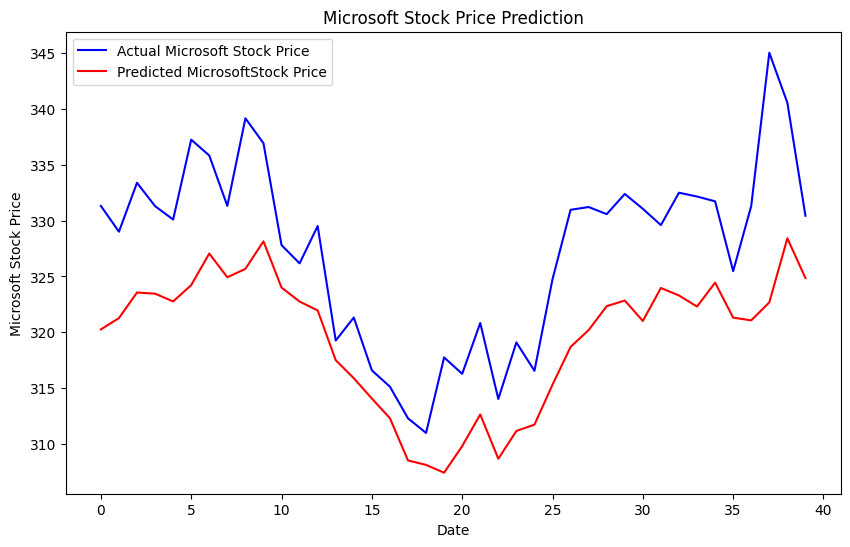

In [168]:
plt.figure(figsize=(10,6))
plt.plot(microsoft_testing_processed[:, :1], color='blue', label='Actual Microsoft Stock Price')
plt.plot(pred_inv[:,:1] , color='red', label='Predicted MicrosoftStock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.show()
